# Zadání

V Edinburghu, stejně jako v dalších městech, funguje systém "bike sharing" - ve městě jsou stanice s koly, člověk si může nějaké půjčit a potom ho vrátit v nějaké další stanici. Problém je, že v některých stanicích se kola pravidelně hromadí a jinde naopak chybí. Provozovatel kol, firma Just Eat Cycles, zadala projekt, jehož cílem je systém zefektivnit. Výstup projektu je otevřený: může to být plán dodávek převážejících kola mezi stanicemi nebo návrh nové cenotvorby.

Coby datový analytik jste součástí týmu, který na projektu pracuje. Vaším úkolem je zpracovat relevantní data a zjistit z nich informace užitečné pro zbytek týmu. Máte k dispozici data o všech výpůjčkách (na ENGETO databázi v tabulce edinburgh_bikes). Proveďte standardní deskriptivní statistiku dat. Také zjistěte minimálně následující informace:

* identifikujte aktivní a neaktivní stanice
* identifikujte nejfrekventovanější stanice
* identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí
* spočítejte vzdálenosti mezi jednotlivými stanicemi
* jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty, zobrazte histogram

*Analýza poptávky:*

* zobrazte vývoj poptávky po půjčování kol v čase
* identifikujte příčiny výkyvů poptávky
* zjistěte vliv počasí na poptávku po kolech (údaje o počasí v Edinburghu jsou v tabulce edinburgh_weather)
* půjčují si lidé kola více o víkendu než během pracovního týdne?

In [1]:
import pandas as pd
#!pip install sqlalchemy
import sqlalchemy
import seaborn as sns
import numpy as np
import matplotlib as mpl
#!pip install PyMySql
#pip install --upgrade pip
from matplotlib import pyplot as plt
from matplotlib import cm

student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(student_conn_string) #engine kde je databaze
query = "select * from edinburgh_bikes"
df = pd.read_sql(query, alchemy_conn)

mpl.rc('figure', figsize=(8,4))
mpl.rc('axes', labelsize=16, titlesize=20)
mpl.rc('lines', linewidth=4)
mpl.rc('legend', fontsize=14, title_fontsize=14)

In [2]:
df.replace('Picady Place','Picardy Place', inplace=True)
df.replace('Bruntsfield','Bruntsfield links', inplace=True)
# df.loc[df['start_station_id']==1024]
# df.to_excel(r'edinbugh_kola.xlsx', index = False)

# IDENTIFIKUJTE AKTIVNÍ A NEAKTIVNÍ STANICE, IDENTIFIKUJTE NEJFREKVENTOVANĚJŠÍ STANICE


In [3]:
selection = ['start_station_id','start_station_name']
start_stations=(df[selection]
                    .assign(count_start=1)
                    .groupby(['start_station_id', 'start_station_name'])
                    .count()
                    .sort_values('count_start',ascending=False)
                   )
start_stations.index.set_names(['id','name'],inplace=True)

selection = ['end_station_id','end_station_name']
end_stations=(df[selection]
                    .assign(count_end=1)
                    .groupby(['end_station_id', 'end_station_name'])
                    .count()
                    .fillna(0)
                    .sort_values('count_end',ascending=False)
             )
end_stations.index.set_names(['id','name'],inplace=True)

# Duplikovaný index
#start_stations[start_stations.index.duplicated()]
#end_stations.loc[[242]]

aktivita = (start_stations
            .join(end_stations, how='outer')
            .assign(total_count = start_stations['count_start']+ end_stations['count_end'])
            .fillna(0)
            .sort_values('total_count', ascending=False)
           )

### Deset nejfrekventovanějších stanic

In [4]:
aktivita.head(10)

,,count_start,count_end,total_count
id,name,,,
265,Meadows East,12715.0,11371.0,24086.0
250,Victoria Quay,8140.0,11479.0,19619.0
1728,Portobello - Kings Road,8036.0,10091.0,18127.0
248,Bristo Square,10999.0,6672.0,17671.0
259,St Andrew Square,10372.0,6943.0,17315.0
262,Canonmills,7589.0,9482.0,17071.0
358,Leith Walk,6554.0,9326.0,15880.0
289,Castle Street,7628.0,6029.0,13657.0
1024,Meadow Place,7508.0,6072.0,13580.0


### Deset nejméně frekventovaných stanic

In [5]:
aktivita.tail(10)

,,count_start,count_end,total_count
id,name,,,
1056,Fort Kinnaird,3.0,6.0,9.0
1057,Pleasance - Edinburgh University Sports Fair,2.0,6.0,8.0
299,Depot Virtual,3.0,5.0,8.0
965,Sustrans - walk cycle event,4.0,3.0,7.0
241,Depot,2.0,3.0,5.0
981,Royal Highland Show - West Gate (19th to 23rd June),1.0,2.0,3.0
1740,Cycling Scotland Conference,1.0,2.0,3.0
1857,City Chambers Launch Station,1.0,0.0,0.0
242,Virtual Depot,0.0,2.0,0.0


# IDENTIFIKUJTE STANICE, NA KTERÝCH SE KOLA HROMADÍ, A STANICE, KDE POTENCIÁLNĚ CHYBÍ

## Stanice, kde se kola nejvíce hromadí

In [6]:
acc = pd.DataFrame(aktivita, columns =['count_start', 'count_end']).assign(bikes_cnt= aktivita.count_end - aktivita.count_start)
acc = acc.sort_values('bikes_cnt', ascending=False).fillna(0)
acc.head(10)

,,count_start,count_end,bikes_cnt
id,name,,,
250,Victoria Quay,8140.0,11479.0,3339.0
358,Leith Walk,6554.0,9326.0,2772.0
1824,Duke Street,5617.0,7961.0,2344.0
1728,Portobello - Kings Road,8036.0,10091.0,2055.0
262,Canonmills,7589.0,9482.0,1893.0
285,Ocean Terminal,5236.0,6991.0,1755.0
258,Stockbridge,5072.0,6779.0,1707.0
257,Portobello,3934.0,5146.0,1212.0
366,Dudley Gardens,1641.0,2574.0,933.0


## Stanice, kde kola chybí

In [7]:
acc.tail(10)

,,count_start,count_end,bikes_cnt
id,name,,,
265,Meadows East,12715.0,11371.0,-1344.0
1024,Meadow Place,7508.0,6072.0,-1436.0
264,Pollock Halls,6076.0,4603.0,-1473.0
289,Castle Street,7628.0,6029.0,-1599.0
1767,Bruntsfield Links,4571.0,2966.0,-1605.0
260,Lauriston Place,5218.0,3014.0,-2204.0
189,City Chambers,4605.0,2223.0,-2382.0
247,Charlotte Square,6834.0,4248.0,-2586.0
259,St Andrew Square,10372.0,6943.0,-3429.0


## Akumulace kol + aktivita stanic

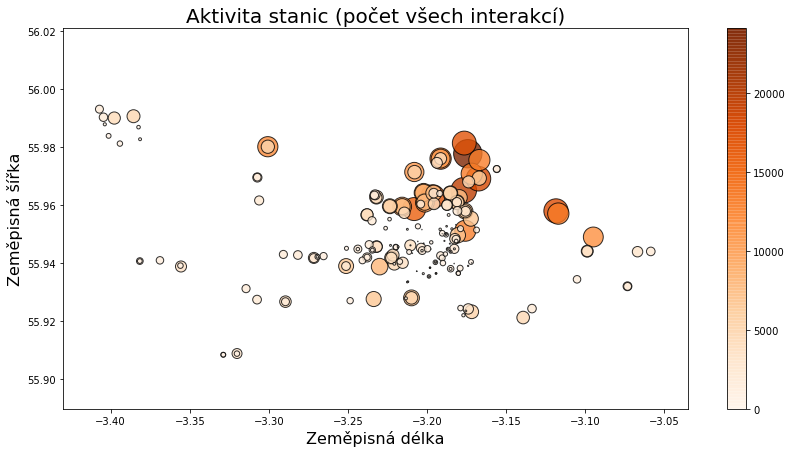

In [8]:
selection = ['start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude']
s_stations=(df[selection]
            .groupby(['start_station_id', 'start_station_name'])
            .mean() #protože u každé výpujčky je lehce odlišná latitude/longitude
            )
s_stations.columns = ['lat', 'long']
s_stations.index.set_names(['id','name'],inplace=True)

selection = ['end_station_id','end_station_name', 'end_station_latitude', 'end_station_longitude']
e_stations=(df[selection]
            .groupby(['end_station_id', 'end_station_name'])
            .mean() 
            )
e_stations.columns = ['lat', 'long']
e_stations.index.set_names(['id','name'],inplace=True)


#stations = pd.concat([e_stations, s_stations], axis=0)
stations = acc[['bikes_cnt']].join(s_stations)
#stations = stations.join(e_stations, lsuffix='e_')

#stations.reset_index().to_excel(r'stations.xlsx', index = False)


fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)
cmap = cm.get_cmap("Oranges")

stations.plot.scatter('long','lat',  ax=ax, s=(aktivita.total_count/30), c=aktivita.total_count, cmap=cmap, edgecolor='k', alpha=0.8)
ax.set_title('Aktivita stanic (počet všech interakcí)')
ax.set_xlabel('Zeměpisná délka')
ax.set_ylabel('Zeměpisná šířka');


# for i in stations.index:
#         ax.text(stations.loc[i, 'long'], stations.loc[i, 'lat'],i)

Text(0, 0.5, 'Zeměpisná šířka')

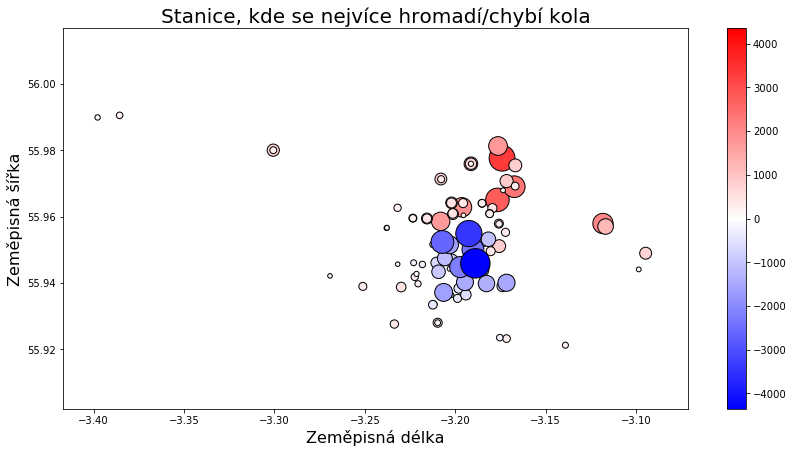

In [9]:
stations_acc = stations.query('abs(bikes_cnt) > 100')

cmap = cm.get_cmap("bwr")

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)

stations_acc.plot.scatter('long','lat',  ax=ax, s=(abs(stations_acc.bikes_cnt)/5), c=stations_acc.bikes_cnt, cmap=cmap, vmin=-4350, vmax=4350,edgecolor='k')
ax.set_title('Stanice, kde se nejvíce hromadí/chybí kola')
ax.set_xlabel('Zeměpisná délka')
ax.set_ylabel('Zeměpisná šířka');

# for i in stations_acc.index:
#         ax.text(stations_acc.loc[i, 'long'], stations_acc.loc[i, 'lat'],i)

 # SPOČÍTEJTE VZDÁLENOSTI MEZI JEDNOTLIVÝMI STANICEMI v KM

In [121]:
# Výpočet vzdálenosti v km 
def distance(lat1, long1, lat2, long2):
    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return round(km,1)


df_distance = stations[['lat', 'long']]#[0:60]
df_distance = df_distance.sort_index(level=0).reset_index(level=1).dropna()
df_distance = df_distance[~df_distance.index.duplicated(keep='first')]

# Rozšířím tabulku o nové sloupce se jmény indexů
for n, i in enumerate(df_distance.index):
    df_distance.insert(n+3, i, None, True) 

# Vypočtu vzdálenost v kilometrech
for p1 in df_distance.index:
    for p2 in df_distance.index:
        lat1 = df_distance['lat'][p1]
        lat2 = df_distance['lat'][p2]
        long1 = df_distance['long'][p1]
        long2 = df_distance['long'][p2]
        df_distance.at[p1, p2] = distance(lat1,long1,lat2,long2)

df_distance


,name,lat,long,171,183,189,225,241,246,247,...,1868,1869,1870,1871,1874,1877,2259,2263,2265,2268
id,,,,,,,,,,,,,,,,,,,,,
171,George Square,55.943084,-3.188311,0,1,0.8,1,3.8,1,1.6,...,14.3,14.4,13.4,13.5,14,14.7,2.9,7.6,8.1,1.5
183,Waverley Bridge,55.951591,-3.191603,1,0,0.2,0.5,3.2,1.8,1,...,13.8,13.9,12.8,13,13.5,14.2,2.1,7.8,8.3,0.6
189,City Chambers,55.950109,-3.190258,0.8,0.2,0,0.4,3.3,1.6,1.1,...,13.9,14.1,13,13.1,13.7,14.3,2.2,7.7,8.2,0.8
225,Waverley Court,55.951734,-3.184179,1,0.5,0.4,0,2.9,1.6,1.4,...,14.2,14.4,13.2,13.5,14,14.6,1.9,7.4,7.9,0.5
241,Depot,55.972373,-3.155833,3.8,3.2,3.3,2.9,0,3.9,3.9,...,15.5,15.6,14.4,14.9,15.3,15.8,1.2,6.4,6.8,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,Port Edgar Marina,55.992957,-3.407156,14.7,14.2,14.3,14.6,15.8,15.7,13.2,...,0.6,0.3,1.4,1.5,1.1,0,14.8,21.9,22.4,14.3
2259,Leith Walk North,55.967918,-3.173586,2.9,2.1,2.2,1.9,1.2,3.2,2.7,...,14.5,14.6,13.4,13.8,14.3,14.8,0,7.2,7.6,1.5
2263,Musselburgh Lidl,55.943880,-3.066754,7.6,7.8,7.7,7.4,6.4,6.7,8.8,...,21.5,21.6,20.5,20.8,21.3,21.9,7.2,0,0.5,7.6


# JAK DLOUHO TRVÁ JEDNA VÝPUJČKA? NAJDĚTE ODLEHLÉ HODNOTY, ZOBRAZTE HISTOGRAM 

# Detekce odlehlých hodnot pomocí z-score
### Přes 800 výpůjček trvalo 24 hodin, velmi zřídka se objevují výpůjčky delší než jeden den. Nejdelší výpůjčka je 16 dní, kdy jde zřejmě o ztracené kolo. Nejvíce dlouhodobých výpůjček (aka ztracených kol) se vyskytuje v období kolem Nového roku, což může ukazovat na novoroční zábavu házení kol do vody.

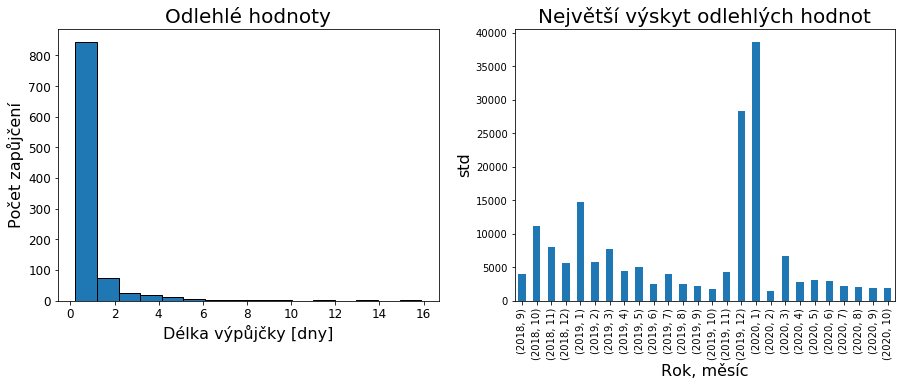

In [113]:
dur_mins = pd.DataFrame(df.duration /60)
dur_mins['zs']= abs(dur_mins.duration - dur_mins.duration.mean()) / dur_mins.duration.std()
odlehle_hodnoty = dur_mins.query('zs>2').sort_values(by='zs') /60/24 #převod na hodiny

# Velikost binu
pocet_dni = 1
x = round(max(odlehle_hodnoty.duration)/pocet_dni)


fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

odlehle_hodnoty['duration'].plot.hist(bins=x, edgecolor='k', fontsize = 12 )
ax1.set_title('Odlehlé hodnoty')
ax1.set_xlabel('Délka výpůjčky [dny]')
ax1.set_ylabel('Počet zapůjčení');

#for i in range(0,round(max(odlehle_hodnoty.duration)/24)):
 #   ax.axvline(i*24, c='g', alpha = 0.5)

df2 = df.groupby([pd.DatetimeIndex(df['started_at']).year, pd.DatetimeIndex(df['started_at']).month]).duration.std()
ax2 = fig.add_subplot(1, 2, 2)
df2.plot(kind='bar', ax = ax2)
ax2.set_title('Největší výskyt odlehlých hodnot')
ax2.set_xlabel('Rok, měsíc')
ax2.set_ylabel('std');


# Nejčastější délka výpůjček
### Nejčastěji se kola půjčují na 5-10 minut. Medián délky zapůjčení se pohybuje celoročně kolem 15 minut, v dubnu 2020 skokově vzrostl až na 45 minut (covid, omezení mhd?) a postupně přes léto klesal až na obvyklé hodnoty.

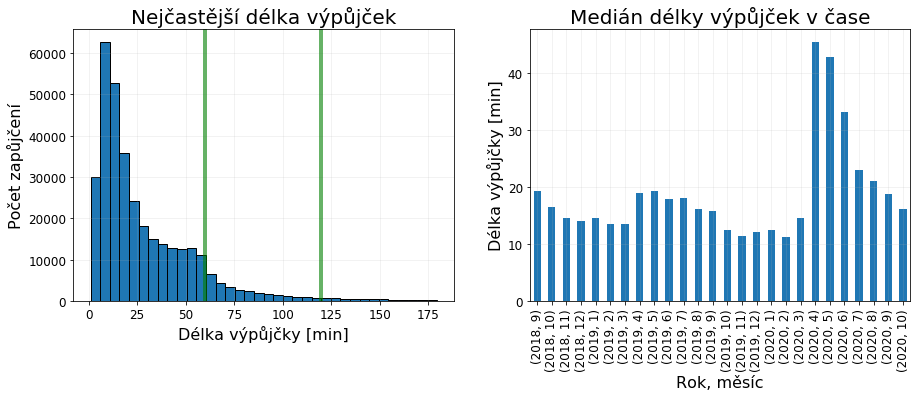

In [120]:
df_vypujcky = dur_mins.query('zs<1').duration

# Velikost binu
pocet_minut = 5
x = round(max(df_vypujcky)/pocet_minut) 

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
df_vypujcky.plot(kind="hist",ax=ax1, bins=x, edgecolor='k', fontsize = 12 )
ax1.set_title('Nejčastější délka výpůjček')
ax1.set_xlabel('Délka výpůjčky [min]')
ax1.set_ylabel('Počet zapůjčení')
ax1.axvline(60, c='g', alpha = 0.6)
ax1.axvline(120, c='green', alpha = 0.6)
ax1.grid(alpha=0.2);

df2 = df.groupby([pd.DatetimeIndex(df['started_at']).year, pd.DatetimeIndex(df['started_at']).month]).duration.median()/60

ax2 = fig.add_subplot(122)
df2.plot(kind='bar', ax=ax2, fontsize = 12)
ax2.set_xlabel('Rok, měsíc')
ax2.set_ylabel('Délka výpůjčky [min]')
ax2.set_title('Medián délky výpůjček v čase')
ax2.grid(alpha=0.2);

# ZOBRAZTE VÝVOJ POPTÁVKY PRO PŮJČOVÁNÍ KOL V ČASE

### Poptávka postupně roste, největší zájem je vždy v letních měsících. V květnu 2020 poptávka vzrostla skokově (důsledek covidu - omezení mhd?). Nejvíce se kola půjčují v soboty (16 %), nejméně v pondělky (13 %). V pracovních dnech je o kola největší zájem mezi 16. a 17. hodinou, o víkendech okolo 13. hodiny.

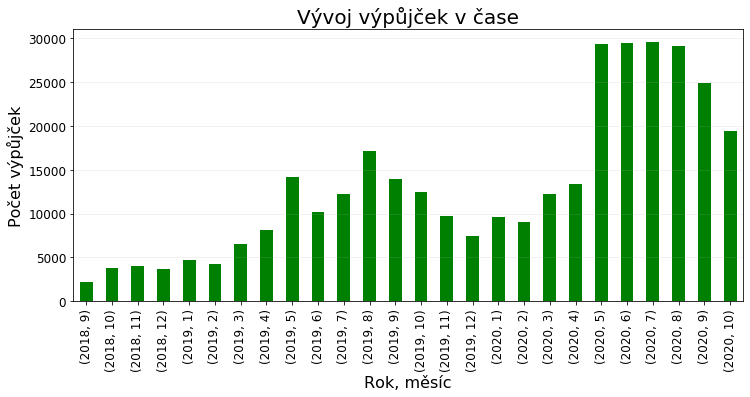

In [123]:
df_cas = df[['started_at']]
df_cas = (df_cas
          .assign(year = pd.DatetimeIndex(df_cas['started_at']).year)
          .assign(month = pd.DatetimeIndex(df_cas['started_at']).month)
          .assign(day = pd.DatetimeIndex(df_cas['started_at']).day)
          .assign(dayofweek = df_cas.started_at.dt.dayofweek)
          .assign(hour = pd.DatetimeIndex(df_cas['started_at']).hour)
          .assign(cnt=1)
         )

df2 = df_cas.groupby(['year','month']).count()
jaro = df2.loc[([2018,2019,2020],[3,4,5]), 'cnt']
leto = df2.loc[([2018,2019,2020],[6,7,8]), 'cnt']
podzim = df2.loc[([2018,2019,2020],[9,10,11]), 'cnt']
zima = df2.loc[([2018,2019,2020],[12,1,2]), 'cnt']

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

df_cas.groupby(['year','month']).count().cnt.plot(kind='bar', color='green',  fontsize = 12)
#jaro.plot(kind='bar', color='green')
ax.set_title('Vývoj výpůjček v čase')
ax.set_xlabel('Rok, měsíc')
ax.set_ylabel('Počet výpůjček')
ax.grid(axis='y', alpha=0.2)


#df[['started_at','duration', 'start_station_id']].to_excel(r'vypujcky.xlsx', index = False)


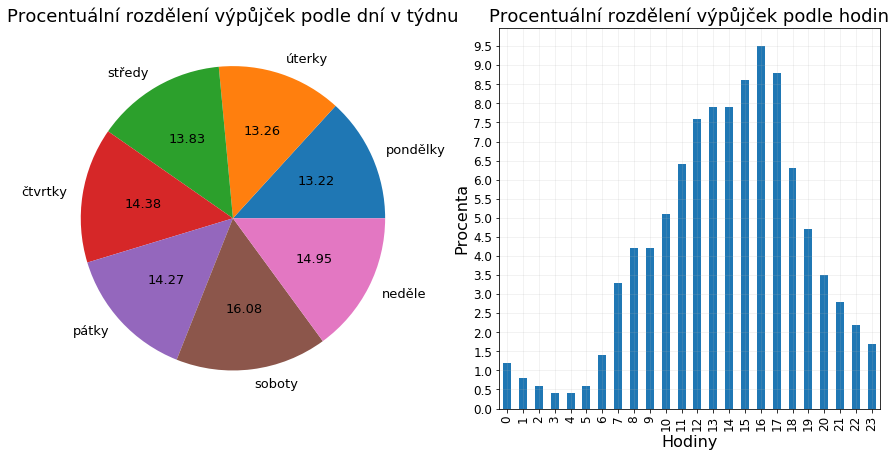

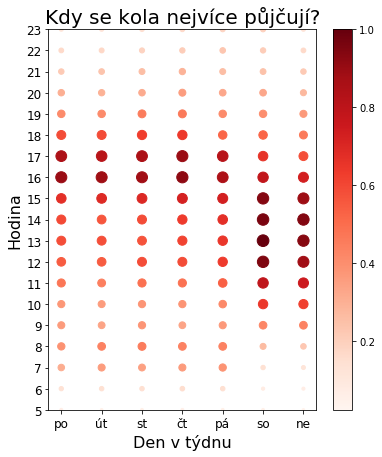

In [125]:
fig = plt.figure(figsize=(15, 7))
pie_kwargs = {'fontsize': 13,  'autopct':'%.2f'}

ax1 = fig.add_subplot(1, 2, 1)
df_cas.groupby(['dayofweek']).count().cnt.plot(kind='pie', labels=['pondělky','úterky','středy','čtvrtky','pátky','soboty','neděle'], ax=ax1, **pie_kwargs)
ax1.set_title('Procentuální rozdělení výpůjček podle dní v týdnu', fontsize=18)
ax1.set_ylabel(' ')

ax2 = fig.add_subplot(1, 2, 2)
total = df_cas.groupby(['hour']).count().cnt.sum()
round(df_cas.groupby(['hour']).count().cnt/total*100,1).plot(kind='bar',fontsize = 12, ax=ax2)
ax2.set_title('Procentuální rozdělení výpůjček podle hodin', fontsize=18)
ax2.set_xlabel('Hodiny')
ax2.set_ylabel('Procenta')
ax2.set_yticks(np.arange(0, 10, 0.5))
ax2.grid(alpha=0.2)

#df_cas.groupby(['dayofweek','hour']).count().cnt.reset_index().to_excel(r'cas.xlsx', index = False)

df2 = pd.DataFrame(df_cas.groupby(['dayofweek','hour']).count().cnt).reset_index()

fig = plt.figure(figsize=(6,7))
cmap = cm.get_cmap("Reds")
size = df2.cnt/40
color = df2.cnt/max(df2.cnt)
labels=['v','po','út','st','čt','pá','so','ne']

ax1 = fig.add_subplot(1, 1, 1)
df2.plot.scatter(x='dayofweek', y='hour', c=color, s=size,cmap=cmap, ax=ax1, fontsize=12)
#ax1.grid()
ax1.set_title('Kdy se kola nejvíce půjčují?')
ax1.set_xlabel('Den v týdnu')
ax1.set_xticklabels(labels)
ax1.set_ylabel('Hodina')
ax1.set_yticks(np.arange(0, 24, 1))
ax1.set_ylim(5,23);


## POČASÍ

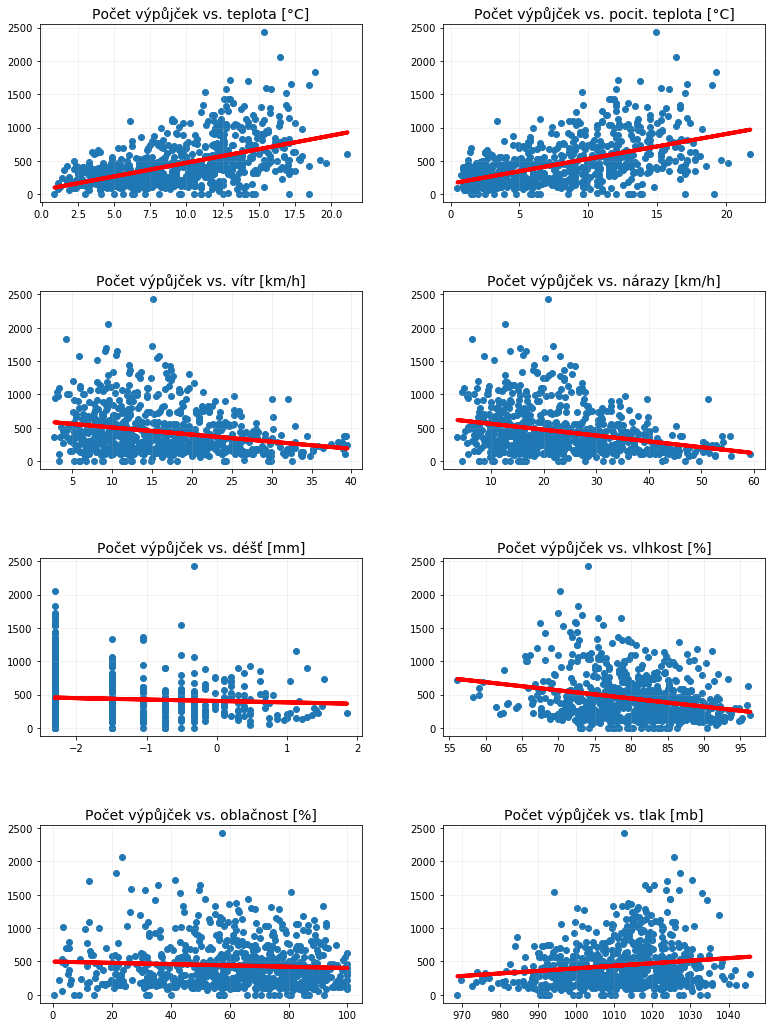

In [96]:
query2 = "select * from edinburgh_weather"
df_weather = pd.read_sql(query2, alchemy_conn)
df_weather.date=pd.to_datetime(df_weather.date)

#Převod na int ze stringů
for column in df_weather.columns[1:-2]:
    df_weather[column] = df_weather[column].str.extract('(\d+)').astype(int)
    
    
df_weather_mean = df_weather.set_index('date').groupby(pd.Grouper(freq='D')).mean()

# Datum a čas výpůjček
df_cas = (df[['started_at']]
          .assign(cnt=1)
          .set_index('started_at')
          .groupby(pd.Grouper(freq='D'))
          .count()
          )

df_cas.index.set_names(['date'], inplace=True)
df_weather = df_weather_mean.join(df_cas).dropna(axis=0)
#df_weather.rain = np.nan_to_num(np.log(df_weather.rain+0.0001))
df_weather.rain = np.log(df_weather.rain+0.1)


from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(13, 18), frameon=False)
xlabel = df_weather.columns
title = ['teplota [°C]','pocit. teplota [°C]', 'vítr [km/h]','nárazy [km/h]','déšť [mm]','vlhkost [%]','oblačnost [%]','tlak [mb]']

for i,n in enumerate(range(len(df_weather.columns)-1)):
    X = df_weather.iloc[:,i].values.reshape(-1, 1)  # iloc[:, 1] is the column of X
    Y = df_weather.iloc[:,-1:].values.reshape(-1, 1)  # df.iloc[:, -1] is the column of Y
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)


    
    ax = fig.add_subplot(4, 2, i+1)
    fig.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.title('Počet výpůjček vs. počasí',fontsize=20)
    ax.scatter(X, Y)
    ax.plot(X, Y_pred, color='red')
    ax.set_title('Počet výpůjček vs. {}'.format(title[n]), fontsize=14)
    ax.grid(alpha=0.2)

In [163]:
# Pandas profiling
#!python -m pip install pandas-profiling
#from pandas_profiling import ProfileReport
#Generate the report. We would use the mpg dataset as sample, title parameter for naming our report, and explorative parameter set to True for Deeper exploration.
#profile = ProfileReport(df_weather, title='Pandas Profiling Report')
#profile.to_file('bikes_weather_report.html')

,temp,feels,wind,gust,rain,humidity,cloud,pressure,cnt
date,,,,,,,,,
2018-09-15,10.500,8.500,14.875,23.500,0.125,83.875,58.125,1017.375,3.0
2018-09-16,12.875,10.625,26.500,43.125,0.000,81.500,79.500,1008.875,10.0
2018-09-17,13.875,13.125,18.000,29.875,0.000,83.000,66.125,1006.375,403.0
2018-09-18,14.125,13.500,16.875,28.500,0.125,86.875,57.750,996.125,126.0
2018-09-19,11.750,8.625,34.750,55.625,0.250,75.750,52.250,995.875,77.0
...,...,...,...,...,...,...,...,...,...
2020-10-26,8.500,5.750,18.000,26.375,0.000,83.750,67.375,986.500,560.0
2020-10-27,7.125,4.625,15.250,22.375,0.000,86.250,54.125,988.625,437.0
2020-10-28,7.250,3.500,24.500,34.000,0.125,83.625,87.500,990.125,559.0


In [88]:
def standardize(arr):
    return(arr-arr.mean())/arr.std()

#X = np.nan_to_num(np.log(df_weather.iloc[:,4].values))  # iloc[:, 1] is the column of X
X = df_weather.iloc[:,4].values
Y = (df_weather.iloc[:,-1:].values)  # df.iloc[:, -1] is the column of Y

X

array([0.125, 0.   , 0.   , 0.125, 0.25 , 0.   , 0.125, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.375, 1.5  , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.375, 0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.375, 0.   , 0.   , 0.25 , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.375, 0.   , 0.   , 0.375, 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.5  , 0.125, 0.   , 0.25 , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.5  , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.125, 0.   ,
       0.125, 0.   ,

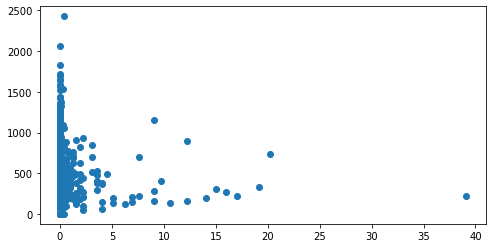

In [92]:
plt.scatter(X*X,Y)

c:\users\barunka\disk google\python\pyladies\datova_analyza\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


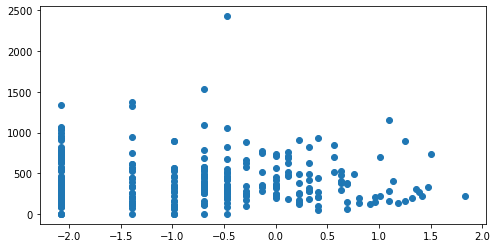

In [91]:
plt.scatter(np.log(X),Y)